In [11]:
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, make_scorer, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
import warnings


In [12]:
warnings.filterwarnings('ignore')

In [13]:
# Muat data bersih yang sudah Anda proses
file_path = 'https://drive.google.com/uc?id=1RnBKwHNLliFJrLMVJfSOAijcOQqYeCQs'
df = pd.read_csv(file_path)

print(f"Data berhasil dimuat. Bentuk data: {df.shape}")
df.head()

Data berhasil dimuat. Bentuk data: (41188, 47)


,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pernah_dihubungi,job_blue-collar,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y
0,56,1,0,1.1,93994.0,-36.4,4857.0,5191.0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,57,1,0,1.1,93994.0,-36.4,4857.0,5191.0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,37,1,0,1.1,93994.0,-36.4,4857.0,5191.0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,40,1,0,1.1,93994.0,-36.4,4857.0,5191.0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,56,1,0,1.1,93994.0,-36.4,4857.0,5191.0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [14]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   campaign                       41188 non-null  int64  
 2   previous                       41188 non-null  int64  
 3   emp.var.rate                   41188 non-null  float64
 4   cons.price.idx                 41188 non-null  float64
 5   cons.conf.idx                  41188 non-null  float64
 6   euribor3m                      41188 non-null  float64
 7   nr.employed                    41188 non-null  float64
 8   pernah_dihubungi               41188 non-null  int64  
 9   job_blue-collar                41188 non-null  int64  
 10  job_entrepreneur               41188 non-null  int64  
 11  job_housemaid                  41188 non-null  int64  
 12  job_management                 41188 non-null 

In [15]:
X = df.drop('y', axis=1)
y = df['y']

print(f"Bentuk X: {X.shape}")
print(f"Bentuk y: {y.shape}")

print("\nDistribusi Target (y):")
print(y.value_counts(normalize=True))

Bentuk X: (41188, 46)
Bentuk y: (41188,)

Distribusi Target (y):
y
0    0.887346
1    0.112654
Name: proportion, dtype: float64


In [16]:
# Identifikasi kolom numerik asli (bukan hasil one-hot encoding)
numeric_cols = ['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx',
                'cons.conf.idx', 'euribor3m', 'nr.employed']

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Terapkan fit_transform pada kolom numerik
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

print("Feature scaling (StandardScaler) telah diterapkan pada kolom numerik.")
X.head()

Feature scaling (StandardScaler) telah diterapkan pada kolom numerik.


,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pernah_dihubungi,job_blue-collar,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,1.533034,-0.565922,-0.349494,0.648092,0.324595,0.886447,0.803623,0.33168,0,0,...,1,0,0,0,1,0,0,0,1,0
1,1.628993,-0.565922,-0.349494,0.648092,0.324595,0.886447,0.803623,0.33168,0,0,...,1,0,0,0,1,0,0,0,1,0
2,-0.290186,-0.565922,-0.349494,0.648092,0.324595,0.886447,0.803623,0.33168,0,0,...,1,0,0,0,1,0,0,0,1,0
3,-0.002309,-0.565922,-0.349494,0.648092,0.324595,0.886447,0.803623,0.33168,0,0,...,1,0,0,0,1,0,0,0,1,0
4,1.533034,-0.565922,-0.349494,0.648092,0.324595,0.886447,0.803623,0.33168,0,0,...,1,0,0,0,1,0,0,0,1,0


In [17]:
# Bagi data menjadi 80% train dan 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

print(f"Bentuk X_train: {X_train.shape}")
print(f"Bentuk X_test: {X_test.shape}")

print(f"\nProporsi 'y' di y_train:\n{y_train.value_counts(normalize=True)}")
print(f"\nProporsi 'y' di y_test:\n{y_test.value_counts(normalize=True)}")

Bentuk X_train: (32950, 46)
Bentuk X_test: (8238, 46)

Proporsi 'y' di y_train:
y
0    0.887344
1    0.112656
Name: proportion, dtype: float64

Proporsi 'y' di y_test:
y
0    0.887351
1    0.112649
Name: proportion, dtype: float64


In [18]:
# --- 1. Hitung scale_pos_weight ---
counter = y_train.value_counts()
scale_pos_weight_value = counter[0] / counter[1]
print(f"Menggunakan scale_pos_weight: {scale_pos_weight_value:.2f}")

# --- 2. Konfigurasi Hyperparameter Tuning ---
print("\n--- Memulai Hyperparameter Tuning (RandomizedSearchCV) ---")

# Model dasar
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight_value,
    random_state=42,
    n_jobs=-1
)

# Grid Parameter yang akan diuji
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7]
}

# Scorer: Fokus optimasi pada F1-score untuk kelas 1 (positif)
f1_scorer_class1 = make_scorer(f1_score, pos_label=1)

# Inisialisasi RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring=f1_scorer_class1,
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# --- 3. Eksekusi Tuning ---
random_search.fit(X_train, y_train)

print("\n--- Tuning Selesai ---")
print(f"Skor F1 (kelas 1) terbaik CV: {random_search.best_score_:.4f}")
print("Parameter terbaik:", random_search.best_params_)

# --- 4. Evaluasi Model Terbaik (Tuned) ---
print("\n--- Hasil Evaluasi Model Terbaik ---")

best_xgb_tuned = random_search.best_estimator_
y_pred_tuned = best_xgb_tuned.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))

Menggunakan scale_pos_weight: 7.88

--- Memulai Hyperparameter Tuning (RandomizedSearchCV) ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Tuning Selesai ---
Skor F1 (kelas 1) terbaik CV: 0.4820
Parameter terbaik: {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}

--- Hasil Evaluasi Model Terbaik ---
Accuracy: 0.8587

Confusion Matrix:
[[6476  834]
 [ 330  598]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      7310
           1       0.42      0.64      0.51       928

    accuracy                           0.86      8238
   macro avg       0.68      0.77      0.71      8238
weighted avg       0.89      0.86      0.87      8238



--- Menganalisis Fitur Terpenting dari Model Terbaik ---

15 Fitur Terpenting yang Digunakan Model:
                 Feature  Importance
7            nr.employed    0.512398
3           emp.var.rate    0.068969
36             month_may    0.051115
8       pernah_dihubungi    0.040162
5          cons.conf.idx    0.039896
38             month_oct    0.032971
45      poutcome_success    0.017512
35             month_mar    0.017381
30     contact_telephone    0.014354
6              euribor3m    0.014069
4         cons.price.idx    0.011929
31             month_aug    0.008701
11         job_housemaid    0.007430
13           job_retired    0.007366
44  poutcome_nonexistent    0.007108

Plot 15 Fitur Terpenting disimpan sebagai 'top_15_feature_importance.png'


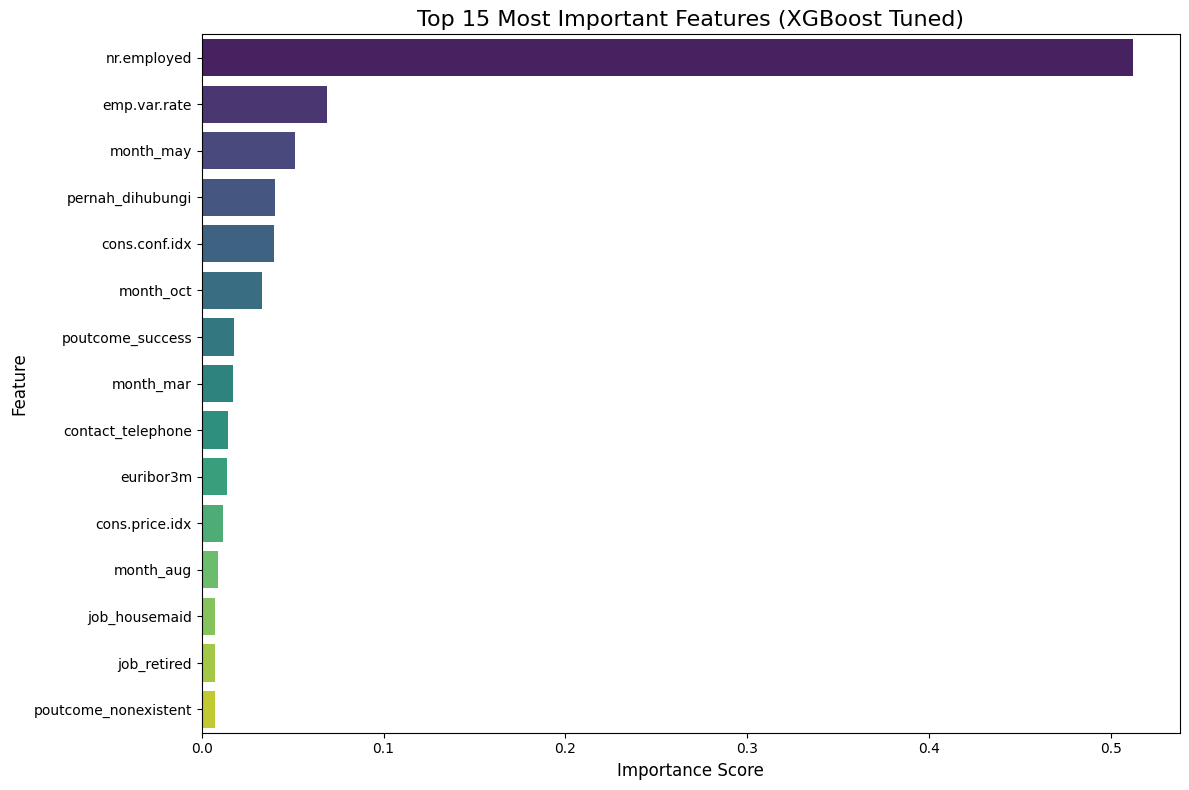

In [19]:
print("--- Menganalisis Fitur Terpenting dari Model Terbaik ---")

# Skor kepentingan dari MODEL TERBAIK (best_xgb_tuned)
importance_scores = best_xgb_tuned.feature_importances_

# Nama-nama fitur
feature_names = X_train.columns

# DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
})

# Urutan DataFrame
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 15 fitur terpenting
top_15_features = feature_importance_df.head(15)

print("\n15 Fitur Terpenting yang Digunakan Model:")
print(top_15_features)

# Plot visualisasi
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_15_features, palette='viridis')
plt.title('Top 15 Most Important Features (XGBoost Tuned)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('top_15_feature_importance.png')
print("\nPlot 15 Fitur Terpenting disimpan sebagai 'top_15_feature_importance.png'")

In [20]:
# Simpan Model Terbaik (XGBoost hasil tuning)
joblib.dump(best_xgb_tuned, 'model_final_xgb.pkl')

# Simpan Scaler
joblib.dump(scaler, 'scaler.pkl')

# Simpan Nama Kolom dari Data Train
model_columns = list(X_train.columns)
joblib.dump(model_columns, 'model_columns.pkl')

print("Semua file berhasil disimpan: model, scaler, dan list kolom.")

Semua file berhasil disimpan: model, scaler, dan list kolom.
